<a href="https://colab.research.google.com/github/YuichH/ML/blob/main/Kaggle/Digit_Recognizer_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#共通


In [ ]:
import sys
# Google colab環境であるか判定
if 'google.colab' in sys.modules:
    # マウントを行う
    from google.colab import drive
    drive.mount('/content/drive')
else:
    print("Not Google Colab")

Mounted at /content/drive


In [ ]:
# Google Colab. やJupyter Lab.でプロットするためには，以下を実行する．
import plotly.io as pio
pio.renderers.default = "colab"

import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
import torchvision.transforms.functional as TF
import torch.optim as optim
import torchvision
import torchvision.datasets as dset
from torch.utils.data import DataLoader
import torch.autograd as autograd
from torchvision import datasets, transforms, models
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import seaborn as sns
from IPython.display import HTML
import tqdm
import cv2
%matplotlib inline
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

rng = np.random.RandomState(1234)
random_state = 42

# from sklearn.preprocessing import LabelEncoder
# LE = LabelEncoder()

In [ ]:
#パラメータ
import argparse
parser = argparse.ArgumentParser()
parser.add_argument("--n_epoch", type=int, default=100)
parser.add_argument("--batch_size", type=int, default=128)
# parser.add_argument("--lr", type=float, default=0.001)
parser.add_argument("--model_name", default="Digit Recognizer")
parser.add_argument("--work_dir", default="/content/drive/MyDrive/Kaggle/Digit Recognizer/")
parser.add_argument("--input_dir", default="/content/drive/MyDrive/Kaggle/Digit Recognizer/input/")
parser.add_argument("--model_dir", default="/content/drive/MyDrive/Kaggle/Digit Recognizer/model/")
opt = parser.parse_args(args=[])
print(opt)

Namespace(n_epoch=100, batch_size=128, model_name='Digit Recognizer', work_dir='/content/drive/MyDrive/Kaggle/Digit Recognizer/', input_dir='/content/drive/MyDrive/Kaggle/Digit Recognizer/input/', model_dir='/content/drive/MyDrive/Kaggle/Digit Recognizer/model/')


#データ

In [ ]:
train = pd.read_csv(opt.input_dir + "train.csv")
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
test = pd.read_csv(opt.input_dir + "test.csv")
test.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
sample_submission = pd.read_csv(opt.input_dir + "sample_submission.csv")
sample_submission.head()

,ImageId,Label
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 251.5 MB


In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28000 entries, 0 to 27999
Columns: 784 entries, pixel0 to pixel783
dtypes: int64(784)
memory usage: 167.5 MB


In [ ]:
train.isnull().sum()

label       0
pixel0      0
pixel1      0
pixel2      0
pixel3      0
           ..
pixel779    0
pixel780    0
pixel781    0
pixel782    0
pixel783    0
Length: 785, dtype: int64

In [ ]:
test.isnull().sum()

pixel0      0
pixel1      0
pixel2      0
pixel3      0
pixel4      0
           ..
pixel779    0
pixel780    0
pixel781    0
pixel782    0
pixel783    0
Length: 784, dtype: int64

#前処理

In [ ]:
X = train.drop("label", axis=1).values
X = X.reshape(-1, 1, 28, 28)
X = X / 255
y = train["label"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, shuffle=True, stratify=y)

In [ ]:
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.int64)
y_test = torch.tensor(y_test, dtype=torch.int64)

In [ ]:
train_dataset = torch.utils.data.TensorDataset(X_train,y_train)
test_dataset = torch.utils.data.TensorDataset(X_test, y_test)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = opt.batch_size, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = opt.batch_size, shuffle = True)
inputs, labels = next(iter(train_loader))

tensor(2)
tensor(0)
tensor(2)
tensor(3)
tensor(3)


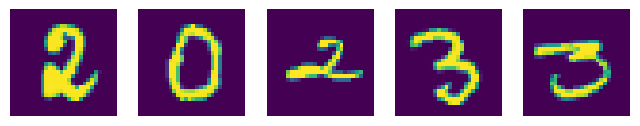

#CNN

In [ ]:
class Net1(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1 , out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.max_pool = nn.MaxPool2d(kernel_size=2)
        self.fc1 = nn.Linear(64*7*7, 100)
        self.fc2 = nn.Linear(100, 10)
        self.softmax = nn.Softmax(dim=-1)
        self.dropuot = nn.Dropout(0.1)

    def forward(self, x):
        x = self.relu(self.conv1(x))    # (batch_size,  1, 28, 28) -> (batch_size, 32, 28, 28)
        x = self.max_pool(x)            # (batch_size, 32, 28, 28) -> (batch_size, 32, 14, 14)
        x = self.relu(self.conv2(x))    # (batch_size, 32, 14, 14) -> (batch_size, 64, 14, 14)
        x = self.max_pool(x)            # (batch_size, 64, 14, 14) -> (batch_size, 64,  7,  7)
        x = x.view(x.size()[0], -1)     # (batch_size, 64,  7,  7) -> (batch_size, 64*7*7)
        x = self.dropuot(x)
        x = self.fc1(x)                 # (batch_size, 64*7*7)     -> (batch_size, 100)
        x = self.dropuot(x)
        x = self.fc2(x)                 # (batch_size, 100)        -> (batch_size, 10)
        x = self.softmax(x)
        return x

net1 = Net1().to(device)

optimizer = optim.Adam(net1.parameters())
criterion = nn.CrossEntropyLoss()

###学習

In [ ]:
train_loss_list = []
train_acc_list = []
val_loss_list = []
val_acc_list = []
for epoch in range(opt.n_epoch):
    train_loss = 0
    train_acc = 0
    val_loss = 0
    val_acc = 0

    net1.train()
    for i, (inputs, labels)  in enumerate(tqdm.tqdm(train_loader, position=0)): #tqdm:プログレスバー
        inputs, labels  = inputs.to(device), labels.to(device)
        batch_size  = inputs.shape[0]
        optimizer.zero_grad()

        outputs = net1(inputs)
        loss = criterion(outputs, labels)
        train_loss += loss.item()
        train_acc += (outputs.max(1)[1] == labels).sum().item()

        loss.backward()
        optimizer.step()

    avg_train_loss = train_loss / len(train_loader.dataset)
    avg_train_acc = train_acc / len(train_loader.dataset)


    net1.eval()
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels  = inputs.to(device), labels.to(device)

            outputs = net1(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            val_acc += (outputs.max(1)[1] == labels).sum().item()

    avg_val_loss = val_loss / len(test_loader.dataset)
    avg_val_acc = val_acc / len(test_loader.dataset)

    print ('Epoch [{}/{}], Loss: {loss:.4f}, val_loss: {val_loss:.4f}, val_acc: {val_acc:.4f}'
                   .format(epoch+1, opt.n_epoch, i+1, loss=avg_train_loss, val_loss=avg_val_loss, val_acc=avg_val_acc))

    train_loss_list.append(avg_train_loss)
    train_acc_list.append(avg_train_acc)
    val_loss_list.append(avg_val_loss)
    val_acc_list.append(avg_val_acc)

print('Finished')

100%|██████████| 263/263 [00:07<00:00, 36.53it/s] 


Epoch [1/100], Loss: 0.0127, val_loss: 0.0118, val_acc: 0.9607


100%|██████████| 263/263 [00:00<00:00, 276.66it/s]


Epoch [2/100], Loss: 0.0117, val_loss: 0.0117, val_acc: 0.9710


100%|██████████| 263/263 [00:01<00:00, 218.34it/s]


Epoch [3/100], Loss: 0.0116, val_loss: 0.0117, val_acc: 0.9715


100%|██████████| 263/263 [00:01<00:00, 215.88it/s]


Epoch [4/100], Loss: 0.0116, val_loss: 0.0116, val_acc: 0.9794


100%|██████████| 263/263 [00:01<00:00, 252.85it/s]


Epoch [5/100], Loss: 0.0116, val_loss: 0.0116, val_acc: 0.9818


100%|██████████| 263/263 [00:00<00:00, 271.85it/s]


Epoch [6/100], Loss: 0.0116, val_loss: 0.0117, val_acc: 0.9780


100%|██████████| 263/263 [00:00<00:00, 269.64it/s]


Epoch [7/100], Loss: 0.0116, val_loss: 0.0116, val_acc: 0.9808


100%|██████████| 263/263 [00:00<00:00, 276.37it/s]


Epoch [8/100], Loss: 0.0115, val_loss: 0.0116, val_acc: 0.9826


100%|██████████| 263/263 [00:00<00:00, 270.30it/s]


Epoch [9/100], Loss: 0.0115, val_loss: 0.0116, val_acc: 0.9836


100%|██████████| 263/263 [00:00<00:00, 273.87it/s]


Epoch [10/100], Loss: 0.0115, val_loss: 0.0116, val_acc: 0.9835


100%|██████████| 263/263 [00:00<00:00, 275.94it/s]


Epoch [11/100], Loss: 0.0115, val_loss: 0.0116, val_acc: 0.9831


100%|██████████| 263/263 [00:00<00:00, 279.53it/s]


Epoch [12/100], Loss: 0.0115, val_loss: 0.0116, val_acc: 0.9846


100%|██████████| 263/263 [00:00<00:00, 277.15it/s]


Epoch [13/100], Loss: 0.0115, val_loss: 0.0116, val_acc: 0.9844


100%|██████████| 263/263 [00:01<00:00, 228.99it/s]


Epoch [14/100], Loss: 0.0115, val_loss: 0.0116, val_acc: 0.9849


100%|██████████| 263/263 [00:01<00:00, 212.96it/s]


Epoch [15/100], Loss: 0.0115, val_loss: 0.0116, val_acc: 0.9855


100%|██████████| 263/263 [00:01<00:00, 226.17it/s]


Epoch [16/100], Loss: 0.0115, val_loss: 0.0116, val_acc: 0.9854


100%|██████████| 263/263 [00:00<00:00, 275.12it/s]


Epoch [17/100], Loss: 0.0115, val_loss: 0.0116, val_acc: 0.9846


100%|██████████| 263/263 [00:00<00:00, 275.62it/s]


Epoch [18/100], Loss: 0.0115, val_loss: 0.0116, val_acc: 0.9838


100%|██████████| 263/263 [00:00<00:00, 275.02it/s]


Epoch [19/100], Loss: 0.0115, val_loss: 0.0116, val_acc: 0.9850


100%|██████████| 263/263 [00:00<00:00, 272.37it/s]


Epoch [20/100], Loss: 0.0115, val_loss: 0.0116, val_acc: 0.9852


100%|██████████| 263/263 [00:00<00:00, 275.89it/s]


Epoch [21/100], Loss: 0.0115, val_loss: 0.0116, val_acc: 0.9860


100%|██████████| 263/263 [00:00<00:00, 275.83it/s]


Epoch [22/100], Loss: 0.0115, val_loss: 0.0116, val_acc: 0.9855


100%|██████████| 263/263 [00:00<00:00, 275.13it/s]


Epoch [23/100], Loss: 0.0115, val_loss: 0.0116, val_acc: 0.9871


100%|██████████| 263/263 [00:00<00:00, 275.36it/s]


Epoch [24/100], Loss: 0.0115, val_loss: 0.0116, val_acc: 0.9868


100%|██████████| 263/263 [00:01<00:00, 252.18it/s]


Epoch [25/100], Loss: 0.0115, val_loss: 0.0116, val_acc: 0.9856


100%|██████████| 263/263 [00:01<00:00, 212.11it/s]


Epoch [26/100], Loss: 0.0115, val_loss: 0.0116, val_acc: 0.9860


100%|██████████| 263/263 [00:01<00:00, 212.32it/s]


Epoch [27/100], Loss: 0.0115, val_loss: 0.0116, val_acc: 0.9862


100%|██████████| 263/263 [00:00<00:00, 272.52it/s]


Epoch [28/100], Loss: 0.0115, val_loss: 0.0116, val_acc: 0.9877


100%|██████████| 263/263 [00:00<00:00, 274.04it/s]


Epoch [29/100], Loss: 0.0115, val_loss: 0.0116, val_acc: 0.9857


100%|██████████| 263/263 [00:00<00:00, 274.05it/s]


Epoch [30/100], Loss: 0.0115, val_loss: 0.0116, val_acc: 0.9881


100%|██████████| 263/263 [00:00<00:00, 275.01it/s]


Epoch [31/100], Loss: 0.0115, val_loss: 0.0116, val_acc: 0.9857


100%|██████████| 263/263 [00:00<00:00, 269.46it/s]


Epoch [32/100], Loss: 0.0115, val_loss: 0.0116, val_acc: 0.9849


100%|██████████| 263/263 [00:00<00:00, 265.90it/s]


Epoch [33/100], Loss: 0.0115, val_loss: 0.0116, val_acc: 0.9861


100%|██████████| 263/263 [00:00<00:00, 269.92it/s]


Epoch [34/100], Loss: 0.0115, val_loss: 0.0116, val_acc: 0.9862


100%|██████████| 263/263 [00:00<00:00, 276.49it/s]


Epoch [35/100], Loss: 0.0115, val_loss: 0.0116, val_acc: 0.9869


100%|██████████| 263/263 [00:00<00:00, 269.62it/s]


Epoch [36/100], Loss: 0.0115, val_loss: 0.0116, val_acc: 0.9874


100%|██████████| 263/263 [00:01<00:00, 213.28it/s]


Epoch [37/100], Loss: 0.0115, val_loss: 0.0116, val_acc: 0.9880


100%|██████████| 263/263 [00:01<00:00, 216.45it/s]


Epoch [38/100], Loss: 0.0115, val_loss: 0.0116, val_acc: 0.9864


100%|██████████| 263/263 [00:01<00:00, 259.51it/s]


Epoch [39/100], Loss: 0.0115, val_loss: 0.0116, val_acc: 0.9868


100%|██████████| 263/263 [00:00<00:00, 273.52it/s]


Epoch [40/100], Loss: 0.0115, val_loss: 0.0116, val_acc: 0.9877


100%|██████████| 263/263 [00:00<00:00, 274.42it/s]


Epoch [41/100], Loss: 0.0115, val_loss: 0.0116, val_acc: 0.9858


100%|██████████| 263/263 [00:01<00:00, 187.36it/s]


Epoch [42/100], Loss: 0.0115, val_loss: 0.0116, val_acc: 0.9856


100%|██████████| 263/263 [00:01<00:00, 147.55it/s]


Epoch [43/100], Loss: 0.0115, val_loss: 0.0116, val_acc: 0.9880


100%|██████████| 263/263 [00:00<00:00, 273.25it/s]


Epoch [44/100], Loss: 0.0115, val_loss: 0.0116, val_acc: 0.9871


100%|██████████| 263/263 [00:00<00:00, 269.52it/s]


Epoch [45/100], Loss: 0.0115, val_loss: 0.0116, val_acc: 0.9865


100%|██████████| 263/263 [00:00<00:00, 272.22it/s]


Epoch [46/100], Loss: 0.0115, val_loss: 0.0116, val_acc: 0.9867


100%|██████████| 263/263 [00:01<00:00, 207.40it/s]


Epoch [47/100], Loss: 0.0115, val_loss: 0.0116, val_acc: 0.9868


100%|██████████| 263/263 [00:01<00:00, 210.30it/s]


Epoch [48/100], Loss: 0.0115, val_loss: 0.0116, val_acc: 0.9888


100%|██████████| 263/263 [00:01<00:00, 247.27it/s]


Epoch [49/100], Loss: 0.0115, val_loss: 0.0116, val_acc: 0.9817


100%|██████████| 263/263 [00:00<00:00, 273.50it/s]


Epoch [50/100], Loss: 0.0115, val_loss: 0.0116, val_acc: 0.9876


100%|██████████| 263/263 [00:00<00:00, 270.08it/s]


Epoch [51/100], Loss: 0.0115, val_loss: 0.0116, val_acc: 0.9886


100%|██████████| 263/263 [00:00<00:00, 272.71it/s]


Epoch [52/100], Loss: 0.0115, val_loss: 0.0116, val_acc: 0.9879


100%|██████████| 263/263 [00:00<00:00, 273.06it/s]


Epoch [53/100], Loss: 0.0115, val_loss: 0.0116, val_acc: 0.9864


100%|██████████| 263/263 [00:00<00:00, 271.80it/s]


Epoch [54/100], Loss: 0.0115, val_loss: 0.0116, val_acc: 0.9865


100%|██████████| 263/263 [00:00<00:00, 270.83it/s]


Epoch [55/100], Loss: 0.0115, val_loss: 0.0116, val_acc: 0.9867


100%|██████████| 263/263 [00:00<00:00, 272.75it/s]


Epoch [56/100], Loss: 0.0115, val_loss: 0.0116, val_acc: 0.9857


100%|██████████| 263/263 [00:00<00:00, 272.96it/s]


Epoch [57/100], Loss: 0.0115, val_loss: 0.0116, val_acc: 0.9832


100%|██████████| 263/263 [00:01<00:00, 218.03it/s]


Epoch [58/100], Loss: 0.0115, val_loss: 0.0116, val_acc: 0.9888


100%|██████████| 263/263 [00:01<00:00, 206.13it/s]


Epoch [59/100], Loss: 0.0115, val_loss: 0.0116, val_acc: 0.9851


100%|██████████| 263/263 [00:01<00:00, 223.05it/s]


Epoch [60/100], Loss: 0.0115, val_loss: 0.0116, val_acc: 0.9869


100%|██████████| 263/263 [00:00<00:00, 272.00it/s]


Epoch [61/100], Loss: 0.0115, val_loss: 0.0116, val_acc: 0.9880


100%|██████████| 263/263 [00:00<00:00, 272.28it/s]


Epoch [62/100], Loss: 0.0115, val_loss: 0.0116, val_acc: 0.9862


100%|██████████| 263/263 [00:00<00:00, 271.62it/s]


Epoch [63/100], Loss: 0.0115, val_loss: 0.0116, val_acc: 0.9867


100%|██████████| 263/263 [00:00<00:00, 270.47it/s]


Epoch [64/100], Loss: 0.0115, val_loss: 0.0116, val_acc: 0.9854


100%|██████████| 263/263 [00:00<00:00, 275.04it/s]


Epoch [65/100], Loss: 0.0115, val_loss: 0.0116, val_acc: 0.9869


100%|██████████| 263/263 [00:00<00:00, 270.72it/s]


Epoch [66/100], Loss: 0.0115, val_loss: 0.0116, val_acc: 0.9871


100%|██████████| 263/263 [00:00<00:00, 268.37it/s]


Epoch [67/100], Loss: 0.0115, val_loss: 0.0116, val_acc: 0.9860


100%|██████████| 263/263 [00:00<00:00, 271.83it/s]


Epoch [68/100], Loss: 0.0115, val_loss: 0.0116, val_acc: 0.9870


100%|██████████| 263/263 [00:01<00:00, 239.99it/s]


Epoch [69/100], Loss: 0.0115, val_loss: 0.0116, val_acc: 0.9868


100%|██████████| 263/263 [00:01<00:00, 212.42it/s]


Epoch [70/100], Loss: 0.0115, val_loss: 0.0116, val_acc: 0.9869


100%|██████████| 263/263 [00:01<00:00, 213.67it/s]


Epoch [71/100], Loss: 0.0115, val_loss: 0.0116, val_acc: 0.9868


100%|██████████| 263/263 [00:00<00:00, 270.57it/s]


Epoch [72/100], Loss: 0.0115, val_loss: 0.0116, val_acc: 0.9873


100%|██████████| 263/263 [00:01<00:00, 188.39it/s]


Epoch [73/100], Loss: 0.0115, val_loss: 0.0116, val_acc: 0.9876


100%|██████████| 263/263 [00:01<00:00, 144.48it/s]


Epoch [74/100], Loss: 0.0115, val_loss: 0.0116, val_acc: 0.9870


100%|██████████| 263/263 [00:01<00:00, 172.21it/s]


Epoch [75/100], Loss: 0.0115, val_loss: 0.0116, val_acc: 0.9873


100%|██████████| 263/263 [00:01<00:00, 147.96it/s]


Epoch [76/100], Loss: 0.0115, val_loss: 0.0116, val_acc: 0.9879


100%|██████████| 263/263 [00:02<00:00, 126.84it/s]


Epoch [77/100], Loss: 0.0115, val_loss: 0.0116, val_acc: 0.9889


100%|██████████| 263/263 [00:02<00:00, 96.35it/s] 


Epoch [78/100], Loss: 0.0115, val_loss: 0.0116, val_acc: 0.9854


100%|██████████| 263/263 [00:00<00:00, 266.68it/s]


Epoch [79/100], Loss: 0.0115, val_loss: 0.0116, val_acc: 0.9873


100%|██████████| 263/263 [00:00<00:00, 271.04it/s]


Epoch [80/100], Loss: 0.0115, val_loss: 0.0116, val_acc: 0.9893


100%|██████████| 263/263 [00:00<00:00, 271.92it/s]


Epoch [81/100], Loss: 0.0115, val_loss: 0.0116, val_acc: 0.9879


100%|██████████| 263/263 [00:00<00:00, 272.92it/s]


Epoch [82/100], Loss: 0.0115, val_loss: 0.0116, val_acc: 0.9880


100%|██████████| 263/263 [00:00<00:00, 272.74it/s]


Epoch [83/100], Loss: 0.0115, val_loss: 0.0116, val_acc: 0.9869


100%|██████████| 263/263 [00:00<00:00, 273.44it/s]


Epoch [84/100], Loss: 0.0115, val_loss: 0.0116, val_acc: 0.9864


100%|██████████| 263/263 [00:00<00:00, 270.21it/s]


Epoch [85/100], Loss: 0.0115, val_loss: 0.0116, val_acc: 0.9875


100%|██████████| 263/263 [00:00<00:00, 271.65it/s]


Epoch [86/100], Loss: 0.0115, val_loss: 0.0116, val_acc: 0.9856


100%|██████████| 263/263 [00:01<00:00, 241.05it/s]


Epoch [87/100], Loss: 0.0115, val_loss: 0.0116, val_acc: 0.9880


100%|██████████| 263/263 [00:01<00:00, 213.56it/s]


Epoch [88/100], Loss: 0.0115, val_loss: 0.0116, val_acc: 0.9864


100%|██████████| 263/263 [00:01<00:00, 215.18it/s]


Epoch [89/100], Loss: 0.0115, val_loss: 0.0116, val_acc: 0.9849


100%|██████████| 263/263 [00:00<00:00, 267.37it/s]


Epoch [90/100], Loss: 0.0115, val_loss: 0.0116, val_acc: 0.9876


100%|██████████| 263/263 [00:00<00:00, 263.26it/s]


Epoch [91/100], Loss: 0.0115, val_loss: 0.0116, val_acc: 0.9865


100%|██████████| 263/263 [00:00<00:00, 270.72it/s]


Epoch [92/100], Loss: 0.0115, val_loss: 0.0116, val_acc: 0.9851


100%|██████████| 263/263 [00:00<00:00, 270.49it/s]


Epoch [93/100], Loss: 0.0115, val_loss: 0.0116, val_acc: 0.9875


100%|██████████| 263/263 [00:00<00:00, 270.31it/s]


Epoch [94/100], Loss: 0.0115, val_loss: 0.0116, val_acc: 0.9889


100%|██████████| 263/263 [00:01<00:00, 258.84it/s]


Epoch [95/100], Loss: 0.0115, val_loss: 0.0116, val_acc: 0.9867


100%|██████████| 263/263 [00:00<00:00, 272.70it/s]


Epoch [96/100], Loss: 0.0115, val_loss: 0.0116, val_acc: 0.9869


100%|██████████| 263/263 [00:00<00:00, 269.27it/s]


Epoch [97/100], Loss: 0.0115, val_loss: 0.0116, val_acc: 0.9876


100%|██████████| 263/263 [00:01<00:00, 249.20it/s]


Epoch [98/100], Loss: 0.0115, val_loss: 0.0116, val_acc: 0.9871


100%|██████████| 263/263 [00:01<00:00, 197.69it/s]


Epoch [99/100], Loss: 0.0115, val_loss: 0.0116, val_acc: 0.9864


100%|██████████| 263/263 [00:01<00:00, 214.26it/s]


Epoch [100/100], Loss: 0.0115, val_loss: 0.0116, val_acc: 0.9852
Finished


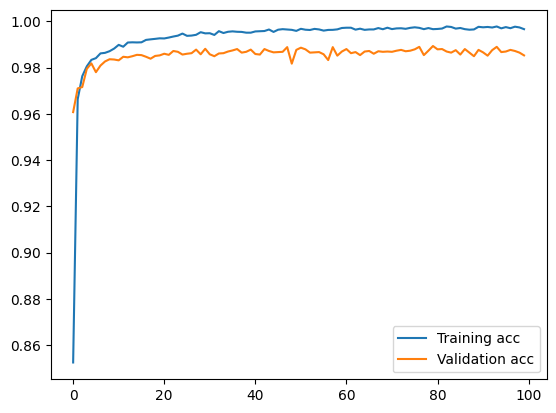

In [ ]:
plt.plot(train_acc_list, label='Training acc')
plt.plot(val_acc_list, label='Validation acc')
plt.legend()

In [ ]:
torch.save(net1, '{}model/{}_{}.pt'.format(opt.work_dir, opt.model_name, opt.n_epoch))

###推論

In [ ]:
net1 = torch.load('{}model/{}_{}.pt'.format(opt.work_dir, opt.model_name, opt.n_epoch))
net1 = net1.to(device)

In [ ]:
test1 = test.values
test1 = test1.reshape(-1, 1, 28, 28)
test1 = test1 / 255

batch_size = 1
test1 = torch.tensor(test1, dtype=torch.float32)
# test1_dataset = torch.utils.data.TensorDataset(test1)
test1_loader = torch.utils.data.DataLoader(test1, batch_size = batch_size, shuffle = False)

In [ ]:
pred_list = []
with torch.no_grad():
    net1.eval()
    c = 0
    for inputs in tqdm.tqdm(test1_loader):
        inputs = inputs.to(device)
        outputs = net1(inputs)
        _, pred = torch.max(outputs.data, 1)
        pred_list.append(pred.item())

100%|██████████| 28000/28000 [00:16<00:00, 1737.76it/s]


#提出用に整形

In [ ]:
pred_list = np.array(pred_list)
pred_list.shape

(28000,)

In [ ]:
ID_lists= np.arange(1, pred_list.shape[0]+1)

submissions=pd.DataFrame({"ImageId": ID_lists,
                         "Label": pred_list})
submissions.to_csv(opt.work_dir + "submissions.csv", index=False, header=True)